### Surface vessel simulation
In this notebook I will try to simulate the open-loop responses of some ship/surface vessel.
To start, I won't worry about the thruster configuration. Instead I'll just apply various forces to the vessel and see if it behaves realistically. The model will be restricted to 3 degrees of freedom (surge, sway and yaw).


### Vessel model
To simulate the ship, we first need to choose a model that accurately describes the motion of the ship. This includes a kinematic model, which describes the motions themselves without considering the forces involved, and a dynamic model, which models the forces that act on the vessel. 

I will use a 3DOF ship model as described here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6539673/

##### Definitions
First, we define ${\vec{\eta}}$ and its derivative $\dot{\vec{\eta}}$:
$$ {\eta} = [x, y, \psi]^T $$
$$ \dot{\eta} = [\dot{x}, \dot{y}, \dot{\psi}]^T $$

$x$, $y$ and $\psi$ are the cartesian coordinates and the heading of the boat in some earth-fixed reference frame (like the starting position of the vessel). This reference frame will act as our intertial frame of reference. The vector $\vec{\eta}$ is in this fixed reference frame.

##### Kinematic model
We want to use the velocity of the vessel in the body-fixed frame to calculate the velocity of the vessel in the earth-fixed frame.
The velocity of the vessel in the body-fixed frame will be denoted as $v$:
$$ \vec{v} = [u, v, r]^T $$
Where $u$ is the surge velocity, $v$ is the sway velocity and $r$ is the yaw rate.

By applying a rotation transformation $J(\vec{\eta})$, we can transform the body-fixed velocities to the earth-fixed velocities $\dot{\vec{\eta}}$:
$$J(\vec{\eta}) = \dot{\vec{\eta}} $$
$$J = \begin{bmatrix} \cos{\psi} & -\sin{\psi} & 0 \\ \sin{\psi} & \cos{\psi} & 0 \\ 0 & 0 & 1 \end{bmatrix}$$

##### Dynamic model
The dynamic model describes the forces that act on the vessel. We will model the control input as a vector of three elements:
$$ \vec{\tau^c} = [{\tau^c}_{u}, {\tau^c}_{v}, {\tau^c}_{r}]^T $$
Where $X$ is the surge force, $Y$ is the sway force and $N$ is the yaw moment. The model, as described in the paper is given as:
$$ M\dot{\vec{v}} + C^*(\vec{v})\vec{v} + D^*(\vec{v})\vec{v} = \vec{\tau^c} + \vec{\tau^d} $$
Where $M$ is the mass matrix, $C^*$ is the Coriolis matrix, $D^*$ is the damping matrix and ${\vec{\tau}}_E$ are the disturbances (waves and wind).

In this simulation we use a simplified model with assumptions described in the paper. The simplified model is given as:
$$ M\dot{\vec{v}} + C(\vec{v})\vec{v} + D(\vec{v})\vec{v} = \vec{\tau^c} + \vec{\tau^d} $$
In this simplification we have removed some elements of the coriolis and damping matrices, giving us the simplified matrices $C$ and $D$. 

The simplified matrices are given as:
$$ M = 
\begin{bmatrix} 
    m - X_{\dot{u}} & 0 & 0 \\
    0 & m - Y_{\dot{v}} & 0 \\ 
    0 & 0 & I_z - N_{\dot{r}} 
\end{bmatrix} $$

$$ C(\vec{v}) =
\begin{bmatrix} 
    0 & 0 & -(m-Y_{\dot{v}})v \\
    0 & 0 & (m-X_{\dot{u}})u \\ 
    (m-Y_{\dot{v}})v & -(m-X_{\dot{u}})u & 0
\end{bmatrix} $$

$$ D(\vec{v})= D = -
\begin{bmatrix} 
    X_{u} & 0 & 0 \\
    0 & Y_{v} & 0 \\ 
    0 & 0 & N_{r}
\end{bmatrix} $$

Finally, the 3DOF model is given as:

$$ \dot{\vec{\eta}} = J(\vec{\eta})\vec{v} $$
$$ M\dot{\vec{v}} + C(\vec{v}) + D(\vec{v})\vec{v} = \vec{\tau} + \vec{\tau_E} $$

In expanded form:
$$ \dot{x} = u\cos{\psi} - v\sin{\psi} $$
$$ \dot{y} = u\sin{\psi} + v\cos{\psi} $$
$$ \dot{\psi} = r $$
$$ (m - X_{\dot{u}})\dot{u} - (m-Y_{\dot{v}})v\dot{r} + X_u u = {\tau^c}_u$$
$$ (m-Y_{\dot{v}})\dot{v} + (m-X_{\dot{u}})ur + Y_v v = {\tau^c}_u$$
$$ (I_z - N_{\dot{r}})\dot{r} - ((m-X_{\dot{u}}) - (m-Y_{\dot{v}}))uv + N_r r = {\tau^c}_r$$

All these parameters have to be identified for the specific vessel we want to simulate. The paper describes how to do this, but for now I will just use the parameters from the paper.

##### Parameters
The parameters for the vessel are given as:
$$ m_{11} = m- X_{\dot{u}} \approx 50.05 \text{ kg} $$
$$ m_{22} = m- Y_{\dot{v}} \approx 84.36 \text{ kg} $$
$$ m_{33} = I_z - N_{\dot{r}} \approx 17.21 \text{ kg} $$
$$ X_u = 151.6 $$
$$ Y_v = 132.5 $$
$$ N_r = 34.6 $$

So our matrices are given as:
$$ M =
\begin{bmatrix} 
    50.05 & 0 & 0 \\
    0 & 84.36 & 0 \\ 
    0 & 0 & 17.21
\end{bmatrix} $$
$$ C(\vec{v}) =
\begin{bmatrix} 
    0 & 0 & -84.36v \\
    0 & 0 & 50.05u \\ 
    84.36v & -50.05u & 0
\end{bmatrix} $$
$$ D(\vec{v})= D = -
\begin{bmatrix} 
    151.6 & 0 & 0 \\
    0 & 132.5 & 0 \\ 
    0 & 0 & 34.6
\end{bmatrix} $$

### Simulation
Now that we have our model, we will simulate the vessel using the python library do_mpc. This library is used to simulate dynamic systems and has a built-in MPC controller. The library is built on top of CasADi, which is a library for numerical optimization. To start, we will just simulate the model with no disturbances and simple control inputs.

#### Non-linear model
The non-linear model is given as:
$$ \dot{\vec{x}} = \vec{f}(\vec{x}, \vec{\tau}, \vec{\tau^d}) $$
$$ \vec{y} = \vec{x} $$
Where $\vec{x}$ is the state vector and $\vec{u}$ is the control input vector. The state vector is given as:
$$ \vec{x} = [x, y, \psi, u, v, r]^T $$
And the control input vector is given as:
$$ \vec{\tau} = [\tau_u, \tau_v, \tau_r]^T $$

in expanded form:
$$ \dot{x} = u\cos{\psi} - v\sin{\psi} $$
$$ \dot{y} = u\sin{\psi} + v\cos{\psi} $$
$$ \dot{\psi} = r $$
$$ \dot{u} = \frac{m_{22}vr - X_u u + \vec{\tau}_u + \vec{\tau^d}_u}{m_{11}} $$
$$ \dot{v} = \frac{-m_{11}ur - Y_v v + \vec{\tau}_v + \vec{\tau^d}_v}{m_{22}} $$
$$ \dot{r} = \frac{(m_{22}-m_{11})uv - N_r r + \vec{\tau}_r + \vec{\tau^d}_r}{m_{33}} $$



In [10]:
import do_mpc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import sin, cos, tan, pi, exp, sqrt, arctan2

model_type = 'continuous'
model = do_mpc.model.Model(model_type)

#Define the model parameters
m_11 = 50.05
m_22 = 84.36
m_33 = 17.21

Xu = 151.57
Yv = 132.5
Nr = 34.5

# Define the model variables
x = model.set_variable(var_type='_x', var_name='x', shape=(1,1))
y = model.set_variable(var_type='_x', var_name='y', shape=(1,1))
psi = model.set_variable(var_type='_x', var_name='psi', shape=(1,1))
u = model.set_variable(var_type='_x', var_name='u', shape=(1,1))
v = model.set_variable(var_type='_x', var_name='v', shape=(1,1))
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1))
tau_c = model.set_variable(var_type='_u', var_name='tau_c', shape=(3,1))

# Without coriolis matrix
model.set_rhs('x', u*cos(psi) - v*sin(psi))
model.set_rhs('y', u*sin(psi) + v*cos(psi))
model.set_rhs('psi', r)
model.set_rhs('u', (1/m_11)*(-Xu*u + tau_c[0]))
model.set_rhs('v', (1/m_22)*(-Yv*v + tau_c[1]))
model.set_rhs('r', (1/m_33)*(-Nr*r + tau_c[2]))

x0 = np.array([0, 0, 0, 0, 0, 0]).reshape(-1,1)
model.x0 = x0
model.setup()

#### Set simulation parameters

In [11]:
simulator = do_mpc.simulator.Simulator(model)
dt = 0.1
simulator.set_param(t_step = dt)
simulator.setup()
simulator.x0 = x0

#### Run simulation

In [12]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [13]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(10,14))
fig.align_ylabels()

In [14]:
#apply zero disturbance and forward thrust
u0 = np.array([195,0,26.52]).reshape(-1,1)
u1 = np.array([195,0,-26.52]).reshape(-1,1)
sim_time = 15

for i in range(int(sim_time/dt)):
    simulator.make_step(u0)



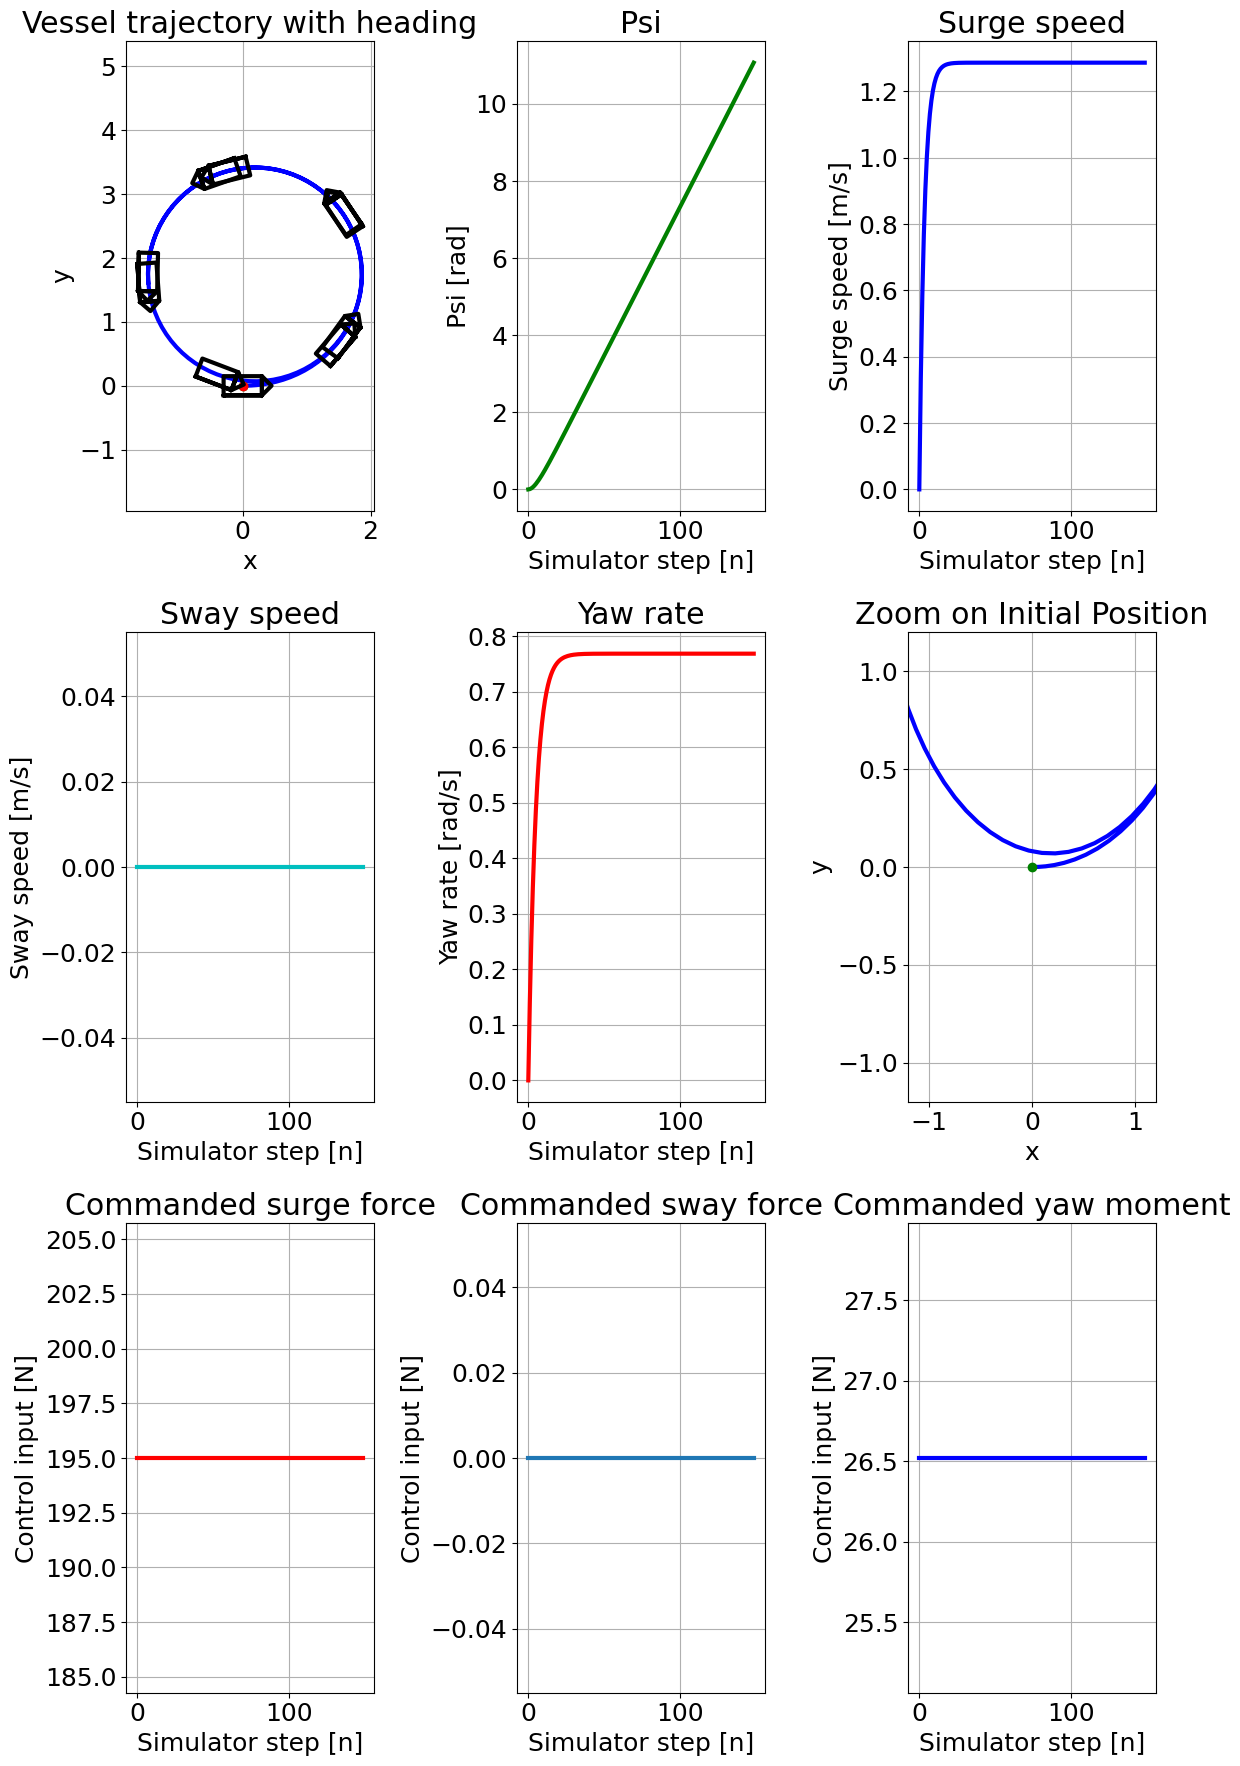

In [17]:
# Define function to draw a simple "boat"
def draw_boat(x, y, psi, ax, length=0.6, width=0.3):
    # Define the boat's body (rectangle) and bow (triangle)
    body = np.array([[-length/2, -length/2, length/2, length/2, -length/2],
                     [-width/2, width/2, width/2, -width/2, -width/2]])
    bow = np.array([[length/2, length/2, 3*length/4, length/2],
                    [-width/2, width/2, 0, -width/2]])
    boat = np.concatenate((body, bow), axis=1)
    
    # Define the rotation matrix
    R = np.array([[np.cos(psi), -np.sin(psi)], [np.sin(psi), np.cos(psi)]])
    
    # Apply rotation and shift
    boat = R @ boat + np.array([[x], [y]])
    
    # Draw the boat on the plot
    ax.plot(boat[0, :], boat[1, :], 'k')

# Create a figure
fig, axs = plt.subplots(3, 3, figsize=(12,18))

# Get the simulation data
data = simulator.data

# Extract x, y, u, and r and convert them to numpy arrays
x_data = np.array(data['_x', 'x']).squeeze()
y_data = np.array(data['_x', 'y']).squeeze()
psi = np.array(data['_x', 'psi']).squeeze()
u_data = np.array(data['_x', 'u']).squeeze()
v_data = np.array(data['_x', 'v']).squeeze()
r_data = np.array(data['_x', 'r']).squeeze()



# First subplot: Vessel trajectory
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0,0].set_title('Vessel trajectory')
axs[0,0].plot(x_data, y_data, 'b', label='Vessel trajectory')
axs[0,0].plot(x_data[0], y_data[0], 'go', label='Start')
axs[0,0].plot(0, 0, 'ro', label='End')
axs[0,0].axis('equal')

# Draw the trajectory with boats
N_boat = 10  # Number of boat instances to draw
for i in np.linspace(0, len(x_data)-1, N_boat, dtype=int):  # indices along the trajectory
    draw_boat(x_data[i], y_data[i], psi[i], axs[0, 0])

# Set labels and title
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Vessel trajectory with heading')


# Second subplot: Psi
axs[0,1].set_xlabel('Simulator step [n]')
axs[0,1].set_ylabel('Psi [rad]')
axs[0,1].set_title('Psi')
axs[0,1].plot(psi_data, 'g', label='Psi')

# Third subplot: Surge speed
axs[0,2].set_xlabel('Simulator step [n]')
axs[0,2].set_ylabel('Surge speed [m/s]')
axs[0,2].set_title('Surge speed')
axs[0,2].plot(u_data, 'b', label='Surge speed')

# Fourth subplot: Sway speed
axs[1,0].set_xlabel('Simulator step [n]')
axs[1,0].set_ylabel('Sway speed [m/s]')
axs[1,0].set_title('Sway speed')
axs[1,0].plot(v_data, 'c', label='Sway speed')

# Fifth subplot: Yaw rate
axs[1,1].set_xlabel('Simulator step [n]')
axs[1,1].set_ylabel('Yaw rate [rad/s]')
axs[1,1].set_title('Yaw rate')
axs[1,1].plot(r_data, 'r', label='Yaw rate')

# Sixth subplot: Zoomed initial position
axs[1,2].set_xlabel('x')
axs[1,2].set_ylabel('y')
axs[1,2].set_title('Zoom on Initial Position')
axs[1,2].plot(x_data, y_data, 'b', label='Vessel trajectory')

# Set x and y limits to zoom in around initial position
zoom_factor = 1.2  # adjust this for different levels of zoom
x_init, y_init = x_data[0], y_data[0]
axs[1,2].set_xlim(x_init - zoom_factor, x_init + zoom_factor)
axs[1,2].set_ylim(y_init - zoom_factor, y_init + zoom_factor)

# Mark the initial position
axs[1,2].plot(x_init, y_init, 'go', label='Start')


# control inputs
axs[2,0].set_xlabel('Simulator step [n]')
axs[2,0].set_ylabel('Control input [N]')
axs[2,0].set_title('Commanded surge force')
axs[2,0].plot(tau_c_data[:,0], 'r', label='Surge force')

axs[2,1].set_xlabel('Simulator step [n]')
axs[2,1].set_ylabel('Control input [N]')
axs[2,1].set_title('Commanded sway force')
axs[2,1].plot(tau_c_data[:,1], '', label='Surge force')

axs[2,2].set_xlabel('Simulator step [n]')
axs[2,2].set_ylabel('Control input [N]')
axs[2,2].set_title('Commanded yaw moment')
axs[2,2].plot(tau_c_data[:,2], 'b', label='Surge force')


# Ensure subplots do not overlap
plt.tight_layout()

